# 2. Classification

In [9]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.activations import relu, selu
from tensorflow.keras.layers import Activation, LeakyReLU, PReLU
from tensorflow.keras.backend import clear_session

## Classification intro

### Supervised learning

- What is supervised learning?
- Training
- Fitting
- Labels
- Error / cost / objective functions

### Classification

- What is classification?
- Different approaches
  - Logistic regression - log loss
  - ANNs, SVMs
  - ...

### No free lunch

- Model selection.
- Parametric / nonparametric models.
- Discriminative / generative modelling.

### Overfitting

- Overfitting
- Underfitting
- Generalisation

### Optimisation

- Hyperparameters

#### Classification with MNIST

- The aim of classification with MNIST
- Get the data
- Recap analysis
  - Size, shape, type
  - Features
  - Missing data, outliers etc.
  - Target feature of dataset (class)

Download the MNIST dataset, getting features X and labels y:

In [ ]:
X, y = fetch_openml('mnist_784', return_X_y=True)

We shall look at the number of unique features in the dataset.

In [ ]:
n_classes = len(np.unique(y))
print(n_classes)

There appear to be 10 unique digit types.

We shall put the data into a NumPy array and analyse the shape of the data:

In [ ]:
X = np.asarray(X)
y = np.asarray(y)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Image shape: {X[0].shape}")

From the shape we can see that we have the full MNIST dataset of 70000 hand written didgets. 

They are yet to be split into a training and testing set and each image has been flattened to a (784,) array rather than the standard (28,28) form.

Now we shall have a look at the image data to see what form it is in.

In [ ]:
print(np.min(X[0]), np.max(X[0]))

Looking at the minimum and maximum values in appears that pixel are of the standard 0-255 intensity form. 

It is beneficial to some machine learning methods for values to be normalised between 0-1, notably neural networks so we shall do this in the data preparation step.

Finally we shall check the datatypes for features and labels.

In [ ]:
print(X.dtype)
print(y.dtype)

The features are of float type as expected but it may be beneficial to convert the string type labels to integers.

#### Preparing the data

  - train, val test sets
  - cross validation
  - reshape / retype

As stated earlier normalising the feature values will be beneficial for machine learning later on.

In [ ]:
X_full = X / 255.0
print(np.min(X_full), np.max(X_full))

We shall also now convert the string type features to integers for use later on.

In [ ]:
y_full = y.astype('int64')
print(y.dtype)

We will need to create a train, validation and test set before we proceed using sklearns `train_test_split`.

In [ ]:
# train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2)

# remove a validation set from the training data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
print(X_full.shape[0])
print(X_train.shape[0])
print(X_val.shape[0])
print(X_test.shape[0])

Now we can train the data and analyse using the validation set before testing on the test set. This will allow us to minimise overfitting by ensuring our model generalises well.

Later on we shall use cross-validation on the entire training set to ensure maximum generalisation, but for now we shall use the the validation set for this.

## 2.1 Artificial Neural Networks (ANNs)

### Neurons

- Neurons structure
- Action potentials ~ activation functions
- Weights, connections etc.

### The perceptron

- Perceptron history
- Input layer
- Output layer
- Activation function
- Weights
- Bias
- Try and apply it to MNIST (lots of neurons?)

In [ ]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train)

In [ ]:
perceptron.score(X_val, y_val)

### Perceptron regularisation

This is a reasonably good result for such a simple model, but this is due to the simplicity of the data set.

One way we can try and improve the results is through regularisation.

** **EXPLAIN REGULARISATION** **

As the model training doesn't take too long we shall try a grid search with `None`, `l1`, `l2` and `ElastiNet` regularisation.

We shall do this with 5-fold cross validation, evaluating the accuracy on the validation set.

** **EXPLAIN CROSS VALIDATION** **

In [ ]:
reg_perceptron = Perceptron(alpha=0.0001, tol=0.001,
                            max_iter=1000, early_stopping=True,
                            validation_fraction=0.1, n_iter_no_change=5,
                            random_state=42, verbose=0, n_jobs=-1)

perceptron_params = [{'penalty': ['None', 'l1', 'l2', 'elasticnet']}]

grid_search = GridSearchCV(reg_perceptron, perceptron_params,
                           scoring='accuracy', cv=5,
                           return_train_score=True,
                           verbose=3)

grid_search.fit(X_train, y_train)

We can now check the optimal parameters of the grid search.

In [ ]:
grid_search.best_params_

It appears l1 regularisation has produced the best results for the MNIST dataset.

### Multi-layer perceptron

- Multiple layers of neurons
- Able to learn more complex patterns

### Training MLPs

- Forward pass
- Backward pass
- Epochs, convergence

### Forward pass

- Calculation of outputs from input
- Calculates loss

### Backpropogation

- Gradient descent
- Learning rate
- Minimise loss function
- Convex optimisation problem
- Chain rule

### Stochastic gradient descent

- What is SGD
- Diagram

### Cross entropy

- What is cross entropy
- Sparse categorical cross entropy

### Classifying MNIST

- Feed forward network
- Dense layers
- Epochs, convergence
- Create a simple MLP for MNIST

In [ ]:
model = Sequential()
model.add(Dense(100, activation="relu", input_shape=[784]))
model.add(Dense(50, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer='sgd', metrics=["accuracy"])

In [ ]:
model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val))

### Analysing model training

We shall use Tensorboard to visualise our model results as well as analyse training.

We shall configure it to create a new subdirectory for each model instance.

In [ ]:
def get_tb_dir():
    curr_dir = os.path.join(os.curdir, "tensorboard_logs")
    tb_dir = time.strftime("model_%Y_%m_%d-%H-%M-%S")
    return os.path.join(curr_dir, tb_dir)

Now we can create a callback during model training for Tensorboard

In [ ]:
tensorboard = TensorBoard(get_tb_dir())

Fitting the model with the callback will then write the logs to it's own directory in `tensorboard_logs`.

In [ ]:
model = Sequential()
model.add(Dense(100, activation="relu", input_shape=[784]))
model.add(Dense(50, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer='sgd', metrics=["accuracy"])

history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard])

Now we can look at the Tensorboard logs

In [ ]:
# !kill 132185
# %reload_ext tensorboard
# %tensorboard --logdir=./tensorboard_logs --port=6006

### Deeper neural networks

- Create a large overfitting network
- Early stopping, check pointing

In [ ]:
model = Sequential()
model.add(Dense(100, activation="relu", input_shape=[784]))
for i in range(30):
    model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer='sgd', metrics=["accuracy"])
model.summary()

In [ ]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val),
                    callbacks=[tensorboard, early_stopping])

As we can see this large model with almost 400,000 parameters was a lot harder to train and generalised far worse on the validation set.

### Vanishing / exploding gradient problem

- What is the vanishing gradient problem

I shall create a Keras wrapper in order to use Scikit's grid search.

With this wrapper we can search for params: 
- `kernel_initializer`: weigh and bias initialisation method
- `optimizer`: optimisation method used in back progogation
- `activation`: activation function used in forward pass
- `lr`: learning rate of the optimiser
- `momentum`: momentum of the optimiser

### Initlialisation

- GloRoot
- He
- LeCeun

In [ ]:
# Function to create model, required for KerasClassifier
def create_init_model(init):
    # Sequential model
    model = Sequential()
    # Input layer with activation layer
    model.add(Dense(100, kernel_input_shape=[784]))
    model.add(get_activation(activation))
    # Hidden layers with activation function
    for i in range(21):
        model.add(Dense(50))
        model.add(get_activation(activation))
    # Output layer
    model.add(Dense(10, activation='sigmoid'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd',
                  metrics=['accuracy'])
    return model

In [ ]:
init_model = KerasClassifier(build_fn=create_init_model, epochs=10)
param_grid = {"init": ['lecun_uniform', 'glorot_normal', 'glorot_uniform',
                       'he_normal', 'he_uniform']}

### Non-saturating activation functions

- Leaky RELU
- SELU

In [ ]:
# Return activation function as layer
def get_activation(activation):
    if (activation == 'relu'):
        return Activation(relu)
    elif (activation == 'selu'):
        return Activation(selu)
    elif (activation == 'leakyrelu'):
        return LeakyReLU()
    elif (activation == 'prelu'):
        return PReLU()
    return False

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(activation='relu'):
    # Sequential model
    model = Sequential()
    # Input layer with activation layer
    model.add(Dense(100, input_shape=[784]))
    model.add(get_activation(activation))
    # Hidden layers with activation function
    for i in range(21):
        model.add(Dense(50))
        model.add(get_activation(activation))
    # Output layer
    model.add(Dense(10, activation='sigmoid'))
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd',
                  metrics=['accuracy'])
    return model

In [ ]:
np.random.seed(42)
act_model = KerasClassifier(build_fn=create_model, epochs=10)
param_grid = {"activation": ['relu', 'selu', 'leakyrelu', 'prelu']}

# grid search
act_grid = RandomizedSearchCV(act_model, param_grid, n_iter=4, cv=2, verbose=0)
act_grid_results = act_grid.fit(X_train, y_train,
                                validation_data=[X_val, y_val],
                                callbacks=[tensorboard, early_stopping],
                                verbose=0)

In [ ]:
act_grid_results.best_params_

### Batching

- Batch normalisation
- Mini-batch
- Implement batching

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=[784]))
model.add(Dense(100, activation="relu"))
for i in range(20):
    model.add(BatchNormalization())
    model.add(Dense(50, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer='sgd', metrics=["accuracy"])
model.summary()

In [ ]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=[X_val, y_val],
                    callbacks=[tensorboard, early_stopping])

### Optimisers

- Momentum
    - For SGD
- Better optimisers
    - Adam
    - Compare some others?

#### Momentum

In [ ]:
model = Sequential()
model.add(BatchNormalization(input_shape=[784]))
model.add(Dense(100, activation="relu"))
for i in range(20):
    model.add(BatchNormalization())
    model.add(Dense(50, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=SGD(momentum=0.9), metrics=["accuracy"])

In [ ]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=[X_val, y_val],
                    callbacks=[tensorboard, early_stopping])

#### Adaptive moment esitmation (Adam)

In [ ]:
adam_model = Sequential()
adam_model.add(Dense(100, activation="relu"))
adam_model.add(BatchNormalization(input_shape=[784]))
for i in range(20):
    adam_model.add(Dense(50, activation="relu"))
    adam_model.add(BatchNormalization())
adam_model.add(Dense(10, activation="softmax"))

adam_model.compile(loss="sparse_categorical_crossentropy",
                   optimizer=Adam(), metrics=["accuracy"])

In [ ]:
clear_session()

history = adam_model.fit(X_train, y_train, epochs=20,
                         validation_data=[X_val, y_val],
                         callbacks=[tensorboard, early_stopping])

### Minibatch Adam optimisation

In [ ]:
clear_session()

history = adam_model.fit(X_train, y_train, epochs=20, batch_size=16,
                         validation_data=[X_val, y_val],
                         callbacks=[tensorboard, early_stopping])

#### Learning rate

In [ ]:
def create_lr_model(lr):
    model = Sequential()
    model.add(BatchNormalization(input_shape=[784]))
    model.add(Dense(100, activation="relu"))
    for i in range(20):
        model.add(BatchNormalization())
        model.add(Dense(50, activation="relu"))
    model.add(Dense(10, activation="softmax"))
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=SGD(lr=lr, momentum=0.9), metrics=["accuracy"])

In [ ]:
np.random.seed(42)
lr_model = KerasClassifier(build_fn=create_model, epochs=10)
param_grid = {"lr": []}

# grid search
lr_grid = GridSearchCV(act_model, param_grid, cv=2, verbose=0)
lr_grid_results = act_grid.fit(X_train, y_train,
                               validation_data=[X_val, y_val],
                               callbacks=[tensorboard, early_stopping],
                               verbose=0)

### Learning rate

- Analyse adjusting learning rate
- Learning rate schedling

### Overfitting in ANNs

- Why large networks can overfit
- l1, l2 loss and regularisation
- Implement regularisation
- Dropout, monte carlo dropout
- Create a network with dropout

In [ ]:
drop_model = Sequential()

drop_model.add(BatchNormalization(input_shape=[784]))
drop_model.add(Dense(100, activation="relu"))

for i in range(20):
    drop_model.add(Dense(50, activation="relu"))
    drop_model.add(BatchNormalization())

drop_model.add(Dense(50, activation="relu"))
drop_model.add(Dropout(rate=0.5))

drop_model.add(Dense(10, activation="softmax"))

drop_model.compile(loss="sparse_categorical_crossentropy",
                   optimizer='sgd', metrics=["accuracy"])

In [ ]:
clear_session()

history = drop_model.fit(X_train, y_train, epochs=20,
                         validation_data=[X_val, y_val],
                         callbacks=[tensorboard, early_stopping])

### Convolutional neural networks (CNN)

- Problems with neural networks and images
- Convolutions, filters
- Convolutional layers, feature maps
- Simple CNN for MNIST

### Training better CNNs

- Stride, step
- Pooling, max pooling
- Better CNN

### Transfer learning

- What is transfer learning
- Use transfer learning with MNIST

### Limitations of ANNs

- Problems with ANNs

## 2.2. Support Vector Machines (SVMs)

Train an SVM (with a chosen Kernel) and perform the same analyses as for ANNs. Interpret  and  discuss  your  results. Does the model overfit? How do they compare with ANNs? And why? How does the type of kernel (e.g.linear, RBF, etc.) impact on performance?

In [4]:
# get MNIST data and prepare for model
X, y = fetch_openml('mnist_784', return_X_y=True)
X = np.asarray(X)
y = np.asarray(y)

In [5]:
# normalise and scale
X_full = X / 255.0
X_full = StandardScaler().fit_transform(X_full)

# convert type to int
y_full = y.astype('int64')

# reduce number of features
# X_reduced = PCA(n_components=392).fit_transform(X_full)

In [6]:
# create a small training set for faster training with a test and val set
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_full,
                                                    test_size=0.7)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.1)

In [7]:
X_train.shape

(18900, 392)

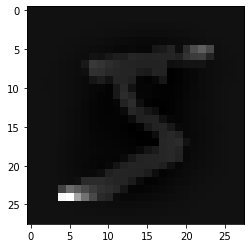

In [11]:
plt.imshow(X_full[0].reshape((28,28)), cmap='gray')

### Support vector machines

- Hyperplane
- Support vectors
- Minimising lagrange multiplier (MIT)

### Linear SVM

- Implementation of SVM on MNIST
- Plot decision boundaries from lab 2

Fit linear SVM to training data

In [ ]:
linear_svm = LinearSVC(loss="squared_hinge", dual=False,
                       max_iter=1000, verbose=10)
linear_svm.fit(X_train, y_train)

Test on validation set.

In [ ]:
score = linear_svm.score(X_val, y_val)
print(score)

### Optimising SVMs

- Hinge loss
- Grid search hyperparameters

### The dual problem

What is the dual problem

### Soft-margin classification

- What is soft-margin classification
- What is the C parameter

Grid search C parameter.

In [40]:
grid_linear_svm = LinearSVC(loss="squared_hinge", dual=False,
                            max_iter=5000)

c_params = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}

c_gridsearch = GridSearchCV(grid_linear_svm, c_params,
                            cv=3, verbose=3)

Fit grid search to train data with 3-fold cross validation

In [41]:
c_gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................. C=0.001, score=0.897, total=   7.0s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.1s remaining:    0.0s


[CV] ............................. C=0.001, score=0.906, total=   6.3s
[CV] C=0.001 .........................................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.4s remaining:    0.0s


[CV] ............................. C=0.001, score=0.906, total=   6.1s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.909, total=   8.0s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.914, total=   8.3s
[CV] C=0.01 ..........................................................
[CV] .............................. C=0.01, score=0.914, total=   8.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.908, total=  11.9s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.913, total=  12.1s
[CV] C=0.1 ...........................................................
[CV] ............................... C=0.1, score=0.915, total=  11.7s
[CV] C=1 .............................................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  9.1min finished


GridSearchCV(cv=3, estimator=LinearSVC(dual=False, max_iter=5000),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]}, verbose=3)

Results from grid search cross-validation.

In [42]:
c_gridsearch.best_params_

{'C': 0.01}

In [43]:
c_gridsearch.best_estimator_

LinearSVC(C=0.01, dual=False, max_iter=5000)

In [44]:
c_gridsearch.best_score_

0.9125595238095238

### Kernels

- Different representations
- Kernels
- Mercer's theorem
- Gram matrix

### The kernel trick

- What is the kernel trick

### Kernel SVMs

- How kernel SVMs work

### Polynomial KSVM

- What is the polynomial kernel
- Implementation

In [49]:
poly_params = {"degree": [2, 3],
               "C": [0.1, 1, 10]}

grid_poly = SVC(kernel='poly', coef0=1, max_iter=5000)

poly_gridsearch = GridSearchCV(grid_poly, poly_params, cv=3)

In [ ]:
poly_gridsearch.fit(X_train, y_train)

/home/kai/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/kai/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/kai/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/home/kai/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/_base.py:249: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, Conv

Results from grid search cross-validation.

In [ ]:
poly_gridsearch.best_params_

In [ ]:
poly_gridsearch.best_estimator_

In [ ]:
poly_gridsearch.best_score_

### Radial basis function (RBF) KSVM

- What is the RBF kernel
- Implementation

In [ ]:
rbf_params = {"gamma": [1, 5, 10, 'scale', 'auto'],
              "C": [0.1, 1, 10]}

grid_rbf = SVC(kernel='rbf', dual=False, max_iter=5000)

rbf_gridsearch = GridSearchCV(grid_rbf, rbf_params,
                              cv=3, versbose=3)

In [ ]:
rbf_gridsearch.best_params_

In [ ]:
rbf_gridsearch.best_estimator_

In [ ]:
rbf_gridsearch.best_score_

### Sigmoid KSVM

- What is the sigmoid kernel
- Implementation

In [ ]:
sigmoid_params = {"gamma": [1, 5, 10, 'scale', 'auto'],
                  "C": [0.1, 1, 10]}

grid_sigmoid = SVC(kernel='poly', coef0=1, max_iter=5000)

sigmoid_gridsearch = GridSearchCV(grid_sigmoid, sigmoid_params, cv=3)

In [ ]:
sigmoid_gridsearch.best_params_

In [ ]:
sigmoid_gridsearch.best_estimator_

In [ ]:
sigmoid_gridsearch.best_score_

### Limitations of SVMs

- Problems with SVMs

## Classification conclusion

#### Comparison of ANNs and SVMs

- Comparison of neural networks and support vector machines.
- Area under ROC curve
- Precision, recall, accuracy...
- TP, TN, FP, FN and rates for each
- Confusion matrix
- Metric
- Validation
- Cross-validation
- Prediction
- Inference
- Interpretability
- Sensitivity vs specificity